<a href="https://colab.research.google.com/github/m-zayed5722/Misc_Projects/blob/main/SWAT_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!mkdir /content/drive/MyDrive/MyFolder
import pandas as pd
import io
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import plotly.graph_objects as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load datasets into 2 dfs: Normal_df that contains normal data and attack_df that contains both normal and anamolous data
Normal_df = pd.read_csv('/content/drive/MyDrive/MyFolder/SWaT_Dataset_Normal_v0.csv')
Attack_df = pd.read_csv('/content/drive/MyDrive/MyFolder/SWaT_Dataset_Attack_v0.csv')

In [ ]:
#Map Normal to 1
target_mapping2 = {
    'Normal': 1,
}
Normal_df["Normal/Attack"] = Normal_df["Normal/Attack"].map(lambda x: target_mapping2[x])

#Map Normal/Attack to 1/-1
target_mapping = {
    'Normal': 1,
    'Attack': -1,
    'A ttack': -1
}
Attack_df["Normal/Attack"] = Attack_df["Normal/Attack"].map(lambda x: target_mapping[x])

In [ ]:
Normal_df2 = Normal_df.copy(deep=True)

#Convert [' Timestamp'] values to datetime type
Normal_df2[' Timestamp'] = pd.to_datetime(Normal_df2[' Timestamp'])
#Normal_df2[' Timestamp'] = pd.to_datetime(Normal_df2[' Timestamp'], format=' %d/%m/%Y %I:%M:%S %p', errors='coerce')

#Convert Timestamp to integer values
Normal_df2[' Timestamp'] = Normal_df2[' Timestamp'].astype(int)

X_train = Normal_df2.loc[:, ' Timestamp':'P603'].values

# Train Isolation Forest model
isf_model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
isf_model.fit(X_train)

IsolationForest(random_state=42)

In [ ]:
anomaly_scores = isf_model.decision_function(X_train)
true_labels = Normal_df2['Normal/Attack'].values

In [ ]:
Attack_df3 = Attack_df.copy(deep=True)
Attack_df3[' Timestamp'] = pd.to_datetime(Attack_df3[' Timestamp'])
Attack_df3[' Timestamp'] = Attack_df3[' Timestamp'].astype(int)
X_test = Attack_df3.loc[:, ' Timestamp':'P603'].values
#anomaly_scores = isf_model.decision_function(X_test)

true_labels = Attack_df3['Normal/Attack'].values

In [ ]:
isf_model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
isf_model.fit(X_test)
anomaly_scores = isf_model.decision_function(X_train)
true_labels = Attack_df3['Normal/Attack'].values

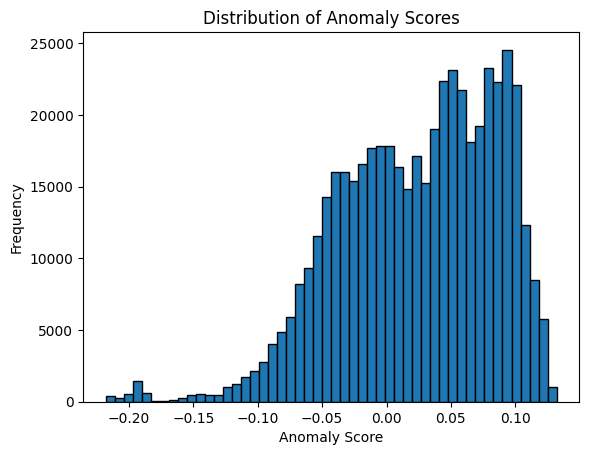

In [ ]:
plt.hist(anomaly_scores, bins=50, edgecolor='black')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.show()

In [ ]:
#
threshold = -0.2
pred = [1 if score >= threshold else -1 for score in anomaly_scores]

In [ ]:
empty_df = pd.DataFrame()
empty_df['Pred_IF'] = pred
empty_df['Pred_IF'].value_counts()
report = classification_report(true_labels, empty_df['Pred_IF'])
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


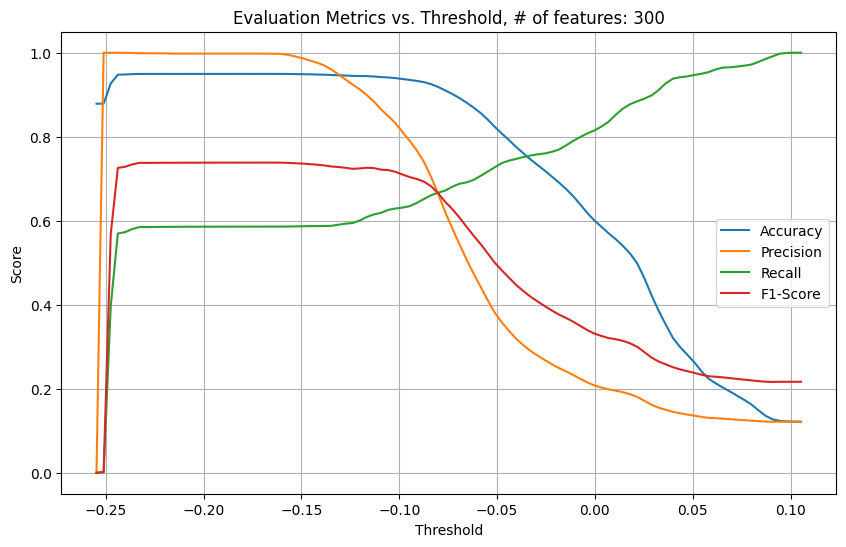

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


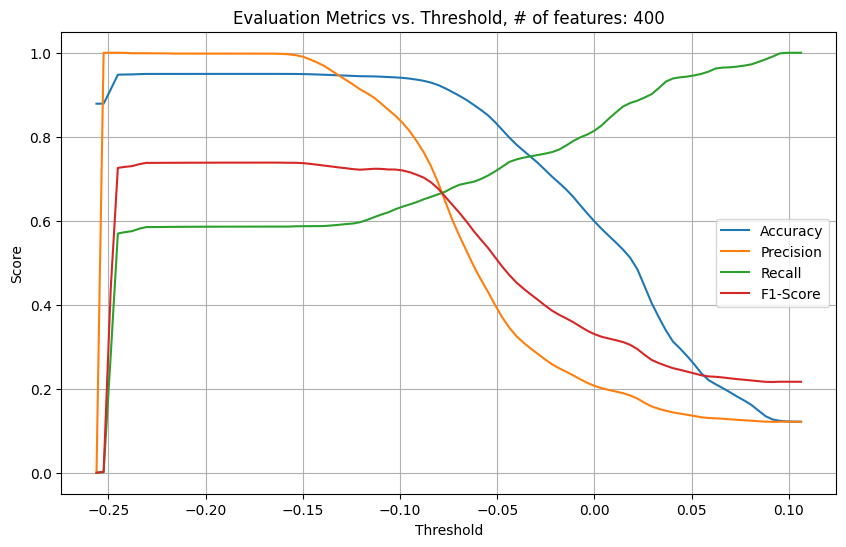

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


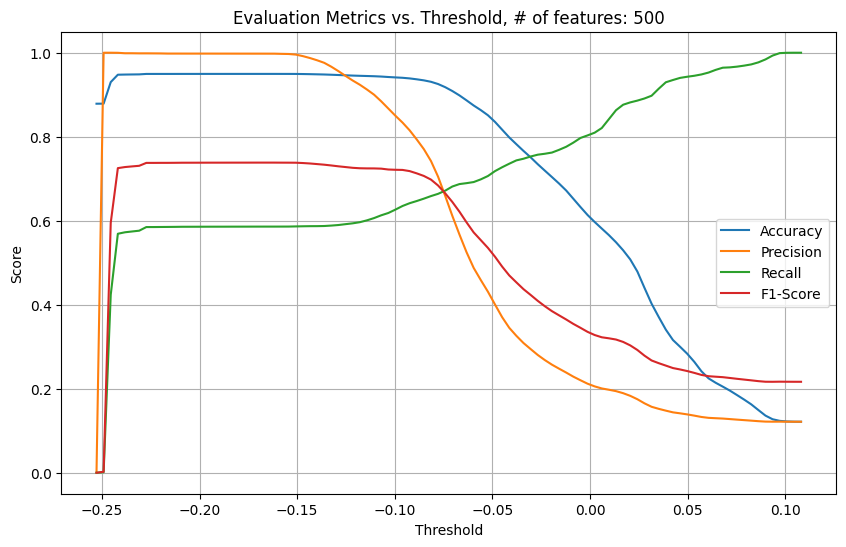

In [ ]:
#Tuning 2 different parameters for IF algorithm
#max_features_values = [1, 0.5, 0.75, 0.25]
#max_samples_values = [0.5, 0.75, None]
n_estimators_values = [300,400,500]
anomaly_scores_arr = []

for n_esti in n_estimators_values:
        isf_model = IsolationForest(n_estimators=n_esti, contamination='auto', random_state=42)
        isf_model.fit(X_train)
        anomaly_scores = isf_model.decision_function(X_test)
        #anomaly_scores_arr.append(anomaly_scores)

        thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), num=100)  # Adjust the range and number of thresholds as desired
        evaluation_results = []

        for threshold in thresholds:
            # Apply the threshold to the anomaly scores
            predicted_labels = [1 if score >= threshold else -1 for score in anomaly_scores]

            # Calculate evaluation metrics
            accuracy = accuracy_score(true_labels, predicted_labels)
            precision = precision_score(true_labels, predicted_labels, pos_label=-1)
            recall = recall_score(true_labels, predicted_labels, pos_label=-1)
            f1 = f1_score(true_labels, predicted_labels, pos_label=-1)

            # Append the evaluation results to a list
            evaluation_results.append((threshold, accuracy, precision, recall, f1))

      # Extract the evaluation metrics from the evaluation_results list
        thresholds, accuracies, precisions, recalls, f1_scores = zip(*evaluation_results)

      # Plot the evaluation metrics
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, accuracies, label='Accuracy')
        plt.plot(thresholds, precisions, label='Precision')
        plt.plot(thresholds, recalls, label='Recall')
        plt.plot(thresholds, f1_scores, label='F1-Score')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Evaluation Metrics vs. Threshold'+  ', # of features: ' + str(n_esti))
        plt.legend()
        plt.grid(True)
        plt.show()


In [ ]:
#thresholds = np.linspace(-0.25, 0.1, num=100)  # Adjust the range and number of thresholds as desired
thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), num=100)  # Adjust the range and number of thresholds as desired

evaluation_results = []

for threshold in thresholds:
    # Apply the threshold to the anomaly scores
    predicted_labels = [1 if score >= threshold else -1 for score in anomaly_scores]

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, pos_label=-1)
    recall = recall_score(true_labels, predicted_labels, pos_label=-1)
    f1 = f1_score(true_labels, predicted_labels, pos_label=-1)


    # Append the evaluation results to a list
    evaluation_results.append((threshold, accuracy, precision, recall, f1))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


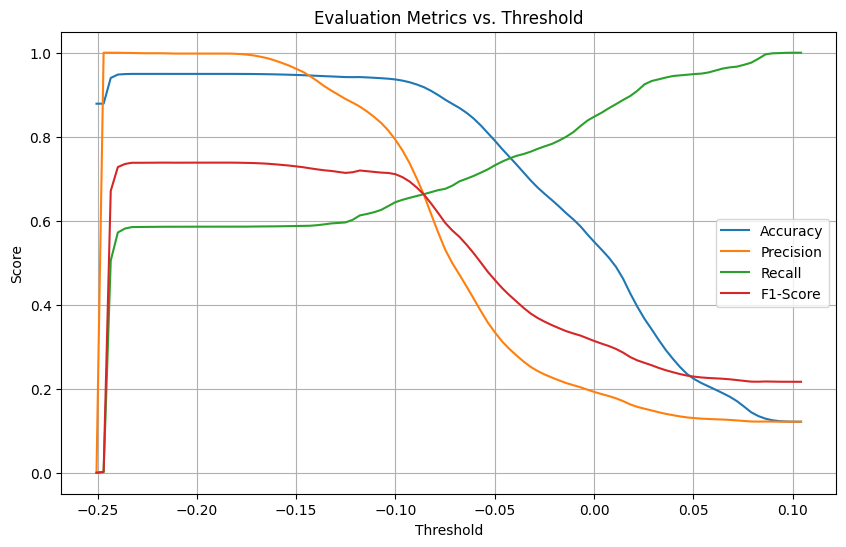

In [ ]:
# Extract the evaluation metrics from the evaluation_results list
thresholds, accuracies, precisions, recalls, f1_scores = zip(*evaluation_results)

# Plot the evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Extract the evaluation metrics from the evaluation_results list
thresholds, accuracies, precisions, recalls, f1_scores = zip(*evaluation_results)

# Create traces for each evaluation metric
accuracy_trace = go.Scatter(x=thresholds, y=accuracies, mode='lines', name='Accuracy')
precision_trace = go.Scatter(x=thresholds, y=precisions, mode='lines', name='Precision')
recall_trace = go.Scatter(x=thresholds, y=recalls, mode='lines', name='Recall')
f1_score_trace = go.Scatter(x=thresholds, y=f1_scores, mode='lines', name='F1-Score')

# Create layout for the plot
layout = go.Layout(
    title='Evaluation Metrics vs. Threshold',
    xaxis=dict(title='Threshold'),
    yaxis=dict(title='Score'),
    legend=dict(x=0.7, y=0.9),
)

# Create figure and add traces to it
fig = go.Figure(data=[accuracy_trace, precision_trace, recall_trace, f1_score_trace], layout=layout)

# Show the plot
fig.show()

In [ ]:
threshold = -0.2
pred = [1 if score >= threshold else -1 for score in anomaly_scores]

#threshold_lower = -0.2
#threshold_upper = 0.05
#pred = [1 if threshold_lower <= score <= threshold_upper else -1 for score in anomaly_scores]


In [ ]:
empty_df = pd.DataFrame()
empty_df['Pred_IF'] = pred
empty_df['Pred_IF'].value_counts()


 1    417856
-1     32063
Name: Pred_IF, dtype: int64

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, pred)
precision = precision_score(true_labels, pred, pos_label=-1)
recall = recall_score(true_labels, pred, pos_label=-1)
f1 = f1_score(true_labels, pred, pos_label=-1)

# Print the evaluation results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9495731453883921
Precision: 0.9979727411658298
Recall: 0.585818641181963
F1-score: 0.738267731069171


In [ ]:
report = classification_report(true_labels, empty_df['Pred_IF'])
print(report)

              precision    recall  f1-score   support

          -1       1.00      0.59      0.74     54621
           1       0.95      1.00      0.97    395298

    accuracy                           0.95    449919
   macro avg       0.97      0.79      0.86    449919
weighted avg       0.95      0.95      0.94    449919



In [ ]:
#Tuning IF model
Normal_df2 = Normal_df.copy(deep=True)
Normal_df2[' Timestamp'] = pd.to_datetime(Normal_df2[' Timestamp'])
Normal_df2[' Timestamp'] = Normal_df2[' Timestamp'].astype(int)

#X_train1 = Normal_df2.iloc[:, :-1].values
X_train = Normal_df2.loc[:, ' Timestamp':'P603'].values

In [ ]:
Attack_df2 = Attack_df.copy(deep=True)
Attack_df2[' Timestamp'] = pd.to_datetime(Attack_df2[' Timestamp'])
Attack_df2[' Timestamp'] = Attack_df2[' Timestamp'].astype(int)
X_test = Attack_df2.loc[:, ' Timestamp':'P603'].values
true_labels = Attack_df2['Normal/Attack'].values

In [ ]:
Attack_df["Normal/Attack"].value_counts()

 1    395298
-1     54621
Name: Normal/Attack, dtype: int64

In [ ]:
#iforest = IsolationForest(contamination='auto', max_samples='auto', max_features=1.0, bootstrap=False, n_jobs=-1, random_state=1)
iforest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
isf_model.fit(X_train)
#pred= iforest.fit_predict(X_test)
pred = isf_model.predict(X_test)


In [ ]:
plot_df = Attack_df.copy(deep=True)

plot_df['Pred_IF'] = pred
plot_df['Pred_IF'].value_counts()

-1    339040
 1    110879
Name: Pred_IF, dtype: int64

In [ ]:
Attack_df["Normal/Attack"].value_counts()

 1    395298
-1     54621
Name: Normal/Attack, dtype: int64

In [ ]:
report = classification_report(Attack_df2['Normal/Attack'], plot_df['Pred_IF'])
print(report)

              precision    recall  f1-score   support

          -1       0.15      0.92      0.26     54621
           1       0.96      0.27      0.42    395298

    accuracy                           0.35    449919
   macro avg       0.56      0.60      0.34    449919
weighted avg       0.86      0.35      0.40    449919



In [ ]:
report = classification_report(Attack_df2['Normal/Attack'], plot_df['Pred_IF'])
print(report)

              precision    recall  f1-score   support

          -1       0.61      0.69      0.64     54621
           1       0.96      0.94      0.95    395298

    accuracy                           0.91    449919
   macro avg       0.78      0.81      0.80    449919
weighted avg       0.91      0.91      0.91    449919



In [ ]:
#Tuning 2 different parameters for IF algorithm
max_features_values = [1, 0.5, 0.75]
max_samples_values = [0.5, 0.75, None]

anomaly_scores_arr = []
for max_samples in max_samples_values:
  for max_features in max_features_values:
        isf_model = IsolationForest(n_estimators=100, contamination='auto', max_samples=max_samples, max_features=max_features, random_state=42)
        isf_model.fit(X_train)
        anomaly_scores = isf_model.decision_function(X_test)
        plt.hist(anomaly_scores, bins=50, edgecolor='black')
        plt.xlabel('Anomaly Score')
        plt.ylabel('Frequency')
        plt.title('Distribution of Anomaly Scores ' + 'max_features: ' +str(max_features)+  ', max_samples: ' + str(max_samples))
        plt.show()
        #anomaly_scores_arr.append(anomaly_scores)
        thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), num=100)  # Adjust the range and number of thresholds as desired

        evaluation_results = []

        for threshold in thresholds:
            # Apply the threshold to the anomaly scores
            predicted_labels = [1 if score >= threshold else -1 for score in anomaly_scores]

            # Calculate evaluation metrics
            accuracy = accuracy_score(true_labels, predicted_labels)
            precision = precision_score(true_labels, predicted_labels)
            recall = recall_score(true_labels, predicted_labels)
            f1 = f1_score(true_labels, predicted_labels)

            # Append the evaluation results to a list
            evaluation_results.append((threshold, accuracy, precision, recall, f1))

      # Extract the evaluation metrics from the evaluation_results list
        thresholds, accuracies, precisions, recalls, f1_scores = zip(*evaluation_results)

      # Plot the evaluation metrics
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, accuracies, label='Accuracy')
        plt.plot(thresholds, precisions, label='Precision')
        plt.plot(thresholds, recalls, label='Recall')
        plt.plot(thresholds, f1_scores, label='F1-Score')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Evaluation Metrics vs. Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()


In [ ]:
for anomaly_scores in anomaly_scores_arr:
  plt.hist(anomaly_scores, bins=50, edgecolor='black')
  plt.xlabel('Anomaly Score')
  plt.ylabel('Frequency')
  plt.title('Distribution of Anomaly Scores ')
  plt.show()

In [ ]:
for anomaly_scores in anomaly_scores_arr:

  thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), num=100)  # Adjust the range and number of thresholds as desired

  evaluation_results = []

  for threshold in thresholds:
      # Apply the threshold to the anomaly scores
      predicted_labels = [1 if score >= threshold else -1 for score in anomaly_scores]

      # Calculate evaluation metrics
      accuracy = accuracy_score(true_labels, predicted_labels)
      precision = precision_score(true_labels, predicted_labels)
      recall = recall_score(true_labels, predicted_labels)
      f1 = f1_score(true_labels, predicted_labels)

      # Append the evaluation results to a list
      evaluation_results.append((threshold, accuracy, precision, recall, f1))

# Extract the evaluation metrics from the evaluation_results list
  thresholds, accuracies, precisions, recalls, f1_scores = zip(*evaluation_results)

# Plot the evaluation metrics
  plt.figure(figsize=(10, 6))
  plt.plot(thresholds, accuracies, label='Accuracy')
  plt.plot(thresholds, precisions, label='Precision')
  plt.plot(thresholds, recalls, label='Recall')
  plt.plot(thresholds, f1_scores, label='F1-Score')
  plt.xlabel('Threshold')
  plt.ylabel('Score')
  plt.title('Evaluation Metrics vs. Threshold')
  plt.legend()
  plt.grid(True)
  plt.show()